# Classifer Model - Playground

## Evaluation Metric: __Accuracy__

The DrivenData Challenge Evaluation Metric is "Classification Rate" (AKA, Accuracy). 

"The metric used for this competition is the classification rate, which calculates the percentage of rows where the predicted class y^
in the submission matches the actual class, y in the test set. The maximum is 1 and the minimum is 0. The goal is to maximize the classification rate.

### Classes: Functional, Non Functional, and Functional Needs Repair

#### Class Frequency of the classes represented in the __Training__ dataset:
* Functional: 54.5%
* Non Functional: 38.7%
* Functional Needs Repair: 6.8%

There is a class imbalance issue, with __Functional Needs Repair__ as the rare class. 

In [264]:
# Load in libraries
import warnings
from importlib import reload
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('seaborn')
import seaborn as sns

import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.formula.api as sms

# ADD IN CORRECT CLASSIFIER MODEL LIBS!!!!!
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold # needed?

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score # needed?

from sklearn.preprocessing import OneHotEncoder

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# needed?
from sklearn.model_selection import GridSearchCV

from xgboost import XGBClassifier




### Define local functions 

In [252]:
def plot_hist(the_df, the_col):
    plt.figure(figsize=(8,5))
    plt.grid(linestyle='dashed', alpha=0.3, zorder=0)
    plt.hist(the_df[the_col], alpha=0.8, zorder=2)
    plt.title(the_col.capitalize())
    plt.show()

def plot_confusion(ytrue, ypred):
    cm_norm = confusion_matrix(ytrue, ypred, normalize='true')
    sns.heatmap(cm_norm, cmap=sns.color_palette('Blues'), fmt='0.5g', annot=True, annot_kws={"va":"bottom"})
    cm = confusion_matrix(ytrue, ypred)
    sns.heatmap(cm, cmap=sns.color_palette('Blues'), fmt='0.5g', annot=True, annot_kws={"va":"top"})
    plt.show()

def print_accuracy(model, X_train, y_train, X_test, y_test, cm=False, get_y_hat=False):
    """ X's should be preprocessed identically.
        Confusion matrix: rows = TRUE, columns = predicted, 
        top L diagonal down to bottom R are TRUE-POSITIVE.
        TRUE-NEG: a 0 outside the TP diagonal.
        False-Pos: column of an item that is not in True row (falsely pred as item).
        False-Neg: row of an item that is not in Pred colum (falsey pred as NOT item)"""
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    acc_test = round(accuracy_score(y_test, y_pred_test),3) * 100
    acc_train = round(accuracy_score(y_train, y_pred_train),3) * 100
    print(f'Test accuracy: {acc_test} %')
    print(f'Train accuracy: {acc_train} %')
    if cm == True:
        print(confusion_matrix(y_test, y_pred_test))
    if get_y_hat == True:
        return y_pred_test

def plot_confusion(model, X_test, y_test, normalize=None, form='.2f'):
    """ normalize{‘true’, ‘pred’, ‘all’}, default=None
        Normalizes over the true (rows), predicted (columns) conditions or all the population. 
        If None, confusion matrix will not be normalized."""
    plot_confusion_matrix(model, X_test, y_test, 
                          cmap=plt.cm.Blues, xticks_rotation='vertical',
                          normalize=normalize, values_format=form)
    plt.show()
    
def plot_feature_importance(model, ohencoder, X_encoder_input, num_features=25):
    top_features_list = []
    for item in zip(ohencoder.get_feature_names(X_encoder_input.columns), model.feature_importances_):
        if item[1] > 0:
            top_features_list.append(item)
    top_feats = sorted(top_features_list, key=lambda x: x[1], reverse=True)
    x_feats_importance = list(map(lambda x: x[1], top_feats[:num_features]))
    y_feats_labels = list(map(lambda x: x[0], top_feats[:num_features]))
    fig, ax = plt.subplots(figsize=(10,10))
    plt.barh(y_feats_labels, x_feats_importance, align='center', color='green', alpha=0.8)
    ax.set_yticks(y_feats_labels)
    ax.set_yticklabels(y_feats_labels)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Importance')
    ax.set_ylabel('Features')
    ax.set_title(f'Top {num_features} Features Ranked by Importance')
    plt.show()

### Load in Training Data

In [208]:
# read in the cleand training data
train_df = pd.read_csv('../data/train_processed_labeled.csv', index_col='id')

#### We created the following new columns for our EDA, but we do not want to use them in modeling for our Classifier.
* recorded_year -  Pulling out the year from date_recorded
* waterpoint_age - Calculate as recorded_year - construction_year
* recorded_good_quality - True if quality_group == 'good', False if  anything other than 'good'
* recorded_good_quantity - True if quanity_group == 'sufficient', False if anythign other than 'sufficient'

In [209]:
train_df.drop(['recorded_year', 'waterpoint_age', 'recorded_good_quality', 'recorded_good_quantity'], axis =1, inplace=True)

## Feature Selection 
Inspecting all the features and making initial choices on which ones to use for modeling.

<AxesSubplot:>

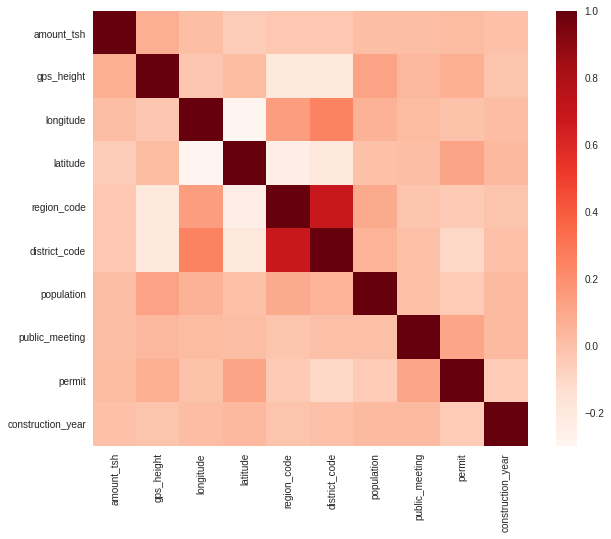

In [210]:
plt.figure(figsize=(10,8))
sns.heatmap(train_df.corr(), square=True, cmap='Reds')

### Initial Feature Selection: NUMERIC
Opt to INCLUDE the following (starting out):
* __region_code__  This is the code for the Region. This feature can take the place of doing One Hot Encoding on the region feature which has the names of the regions.
* __construction_year__


Opt to EXCLUDE the following (starting out):
* __district_code__ feature is (positively) correlated to region_code as Regions are divided into Districts. Looking at the value counts of district_code reveals that some districts are rarely represented. Favoring using region instead.
* __gps_height__  feature is (negatively) correlated to district_code
* __latitude__ feature is (negatively) correlated to district_code
* __longitude__ feature is (positively) correlated to district_code
* __amount_tsh__ (not a lot of information provided by this feature)
* __population__ (not a lot of information provided by this feature)


In [211]:
train_df['district_code'].value_counts()

1     11146
2     10909
3      9998
4      8996
5      4356
6      3586
7      3343
8      1043
30      995
33      874
53      745
43      505
13      391
23      293
63      195
62      109
60       63
80       12
67        6
Name: district_code, dtype: int64

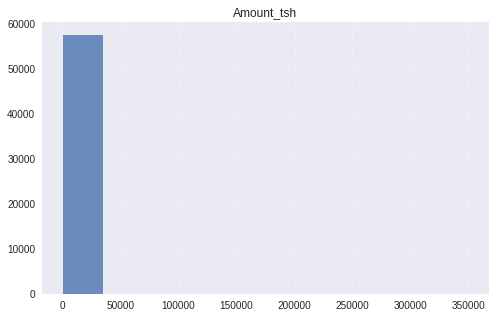

count     57565.000000
mean        327.776129
std        3044.432384
min           0.000000
25%           0.000000
50%           0.000000
75%          30.000000
max      350000.000000
Name: amount_tsh, dtype: float64

In [212]:
plot_hist(train_df, 'amount_tsh')
train_df['amount_tsh'].describe()

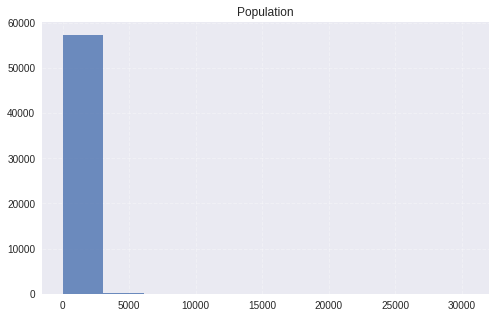

count    57565.000000
mean       185.644975
std        477.825269
min          0.000000
25%          0.000000
50%         35.000000
75%        230.000000
max      30500.000000
Name: population, dtype: float64

In [213]:
plot_hist(train_df, 'population')
train_df['population'].describe()

### Initial Feature Selection: CATEGORICAL

Opt to INCLUDE the following (starting out):
* __basin__
* __scheme_management__
* __extraction_type_class__
* __management__ (consider using management_group if there is too much over fitting)
* __payment_type__
* __water_quality__ (consider using quality_group if there is too much over fitting)
* __quantity__
* __source__ (consider uisng source_type or source_class if there is too much over fitting)
* __waterpoint_type__  (considering using __waterpoint_type_group__ if there is too much over fitting)


Opt to EXCLUDE the following (starting out):
* __wpt_name__ - This identifier does not provide predictive information
* __recorded_by__ - All the same string/ does not provide predictive information
* __region__ - Information already captured by region_code, a numeric feature.
* __extraction_type_group__ and __extraction_type__ - Info already represented in __extraction_type_class__ and these features had too many rare values (see below)
* __management_group__ - Info already represented in __management__, which is more specific
* __payment__ - Info already represented in __payment_type__
* __quality_group__ - Info already represented in __water_quality__
* __quantity_group__ - Info already represented in __quantity__
* __source_type__ and __source_class__ - Info already represented in __source__, which is more specific
* __waterpoint_type_group__ - Info already represented in __waterpoint_type__, which is more specific
* All features with __high cardinality__, setting the cap to 25 (see column cardinality printout below)
* __public_meeting__ - not a lot of information provided by this feature: Similar patterns across all 3 classes)
* __permit__ - not a lot of information provided by this feature: Similar patterns across all 3 classes)

In [214]:
# Checking out the cardinality in categorical columns - # of different labels/ unique string values for a feature/column
for var in train_df.columns:
    # print the first 20 unique values in the Object columns
    if train_df[var].dtype == 'O':
        unique_vals = train_df[var].unique()
        
        print(var, ' cardinality:', unique_vals.size, ', first 20 unique:',  unique_vals[0:20], '\n')

date_recorded  cardinality: 353 , first 20 unique: ['2011-03-14' '2013-03-06' '2013-02-25' '2013-01-28' '2011-07-13'
 '2011-03-13' '2012-10-01' '2012-10-09' '2012-11-03' '2011-08-03'
 '2011-02-20' '2013-02-18' '2012-10-14' '2013-03-15' '2012-10-20'
 '2011-08-04' '2011-07-04' '2011-09-04' '2011-07-22' '2011-02-22'] 

funder  cardinality: 1855 , first 20 unique: ['roman' 'grumeti' 'lottery club' 'unicef' 'action in a'
 'mkinga distric coun' 'dwsp' 'rwssp' 'wateraid' 'isingiro ho' 'private'
 'danida' 'world vision' 'lawatefuka water supply' 'biore' 'rudep'
 'hesawa' 'twe' 'isf' 'african development bank'] 

installer  cardinality: 1903 , first 20 unique: ['roman' 'grumeti' 'world vision' 'unicef' 'artisan' 'dwe' 'dwsp'
 'water aid' 'private' 'danida' 'lawatefuka water sup' 'wedeco' 'danid'
 'twe' 'isf' 'kilolo star' 'district council' 'water' 'wu' 'unknown'] 

wpt_name  cardinality: 36705 , first 20 unique: ['none' 'zahanati' 'kwa mahundi' 'zahanati ya nanyumbu' 'shuleni' 'tajiri'
 'kwa n

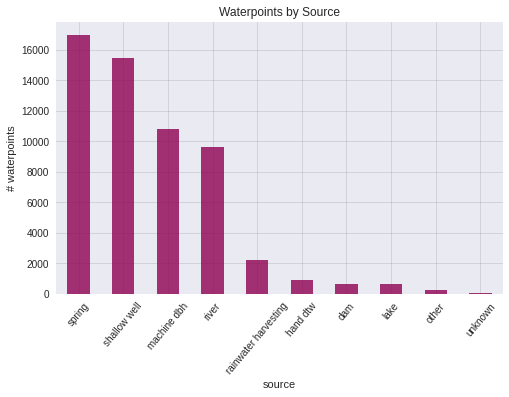

In [224]:
# check out how many unknowns are in source col
by_op_permit_status = train_df.groupby(['status_group','source'])['source'].value_counts()
train_df['source'].value_counts().plot.bar(fontsize=10, rot=50, alpha = 0.80, figsize=(8,5), colormap='PiYG', title='Waterpoints by Source')
plt.grid(color = 'black', alpha = 0.1, linestyle = '-', linewidth = 1)
plt.xlabel('source')
plt.ylabel('# waterpoints')
plt.show()

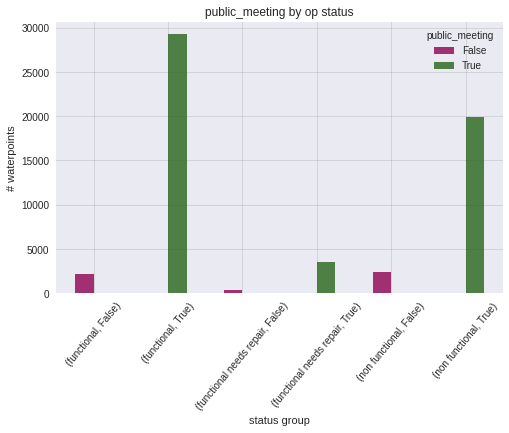

In [223]:
# check out public_meeting
by_op_permit_status = train_df.groupby(['status_group','public_meeting'])['public_meeting'].value_counts()
by_op_permit_status.unstack().plot.bar(fontsize=10, rot=50, alpha = 0.80, figsize=(8,5), colormap='PiYG', title='public_meeting by op status')
plt.grid(color = 'black', alpha = 0.1, linestyle = '-', linewidth = 1)
plt.xlabel('status group')
plt.ylabel('# waterpoints')
plt.show()

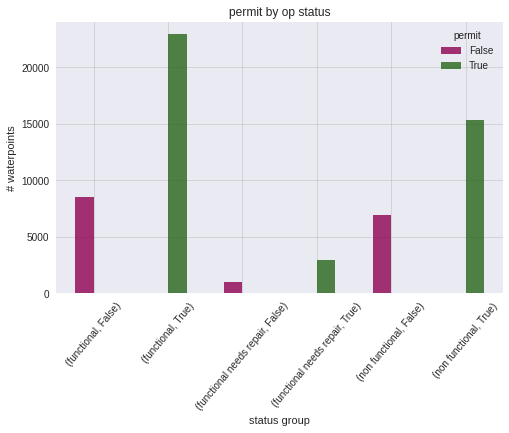

In [225]:
# check out permit
by_op_permit_status = train_df.groupby(['status_group','permit'])['permit'].value_counts()
by_op_permit_status
by_op_permit_status.unstack().plot.bar(fontsize=10, rot=50, alpha = 0.80, figsize=(8,5), colormap='PiYG', title='permit by op status')
plt.grid(color = 'black', alpha = 0.1, linestyle = '-', linewidth = 1)
plt.xlabel('status group')
plt.ylabel('# waterpoints')
plt.show()

### Load in Test Data

In [227]:
# read in the processed test data
test_df = pd.read_csv('../data/test_processed.csv', index_col='id')
print(test_df.shape)
test_df.head(3)

(14389, 38)


,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,basin,subvillage,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,
50785,0.0,2013-02-04,dmdd,1996,dmdd,35.290799,-4.059696,dinamu secondary school,internal,magoma,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
51630,0.0,2013-02-04,government of tanzania,1569,dwe,36.656709,-3.309214,kimnyak,pangani,kimnyak,...,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
17168,0.0,2013-02-01,unknown,1567,unknown,34.767863,-5.004344,puma secondary,internal,msatu,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other


## Feature Engineering
* One Hot Encoding for the categorical variables
* rare labels? binning all the odds and ends lables into a single 'rare' lable?

In [ ]:
'''
basin  OK
scheme_management - has some rare
extraction_type - has lots of rare..use extraction_type_class instead
scheme_managment - has some rare
management - has some rare
payment_type OK
water_quality (consider changeing out for quality_group as this feature may cheat/overfit) -  has some rare..really consider swapping out!
quantity OK
source - has 2 rare unknown and other - consider binning unknown with other
waterpoint_type - offers more specific into on communual standpipe to use this and bin the rare dam and cattle trough into a rare label
'''

In [159]:
var = 'region'
print((train_df[var].value_counts() / len(train_df)).sort_values())

dar es salaam    0.013984
lindi            0.026857
manyara          0.027499
mtwara           0.030053
rukwa            0.031408
tabora           0.034031
mara             0.034205
singida          0.036359
dodoma           0.037835
mwanza           0.039868
tanga            0.044246
pwani            0.045774
ruvuma           0.045861
kigoma           0.048919
kagera           0.057604
arusha           0.058195
shinyanga        0.069087
morogoro         0.069591
kilimanjaro      0.076071
mbeya            0.080587
iringa           0.091966
Name: region, dtype: float64


In [144]:
var = 'waterpoint_type_group'
print((train_df[var].value_counts() / len(train_df)).sort_values())

dam                   0.000122
cattle trough         0.002015
improved spring       0.013602
other                 0.107009
hand pump             0.280969
communal standpipe    0.596282
Name: waterpoint_type_group, dtype: float64


In [145]:
var = 'waterpoint_type'
print((train_df[var].value_counts() / len(train_df)).sort_values())

dam                            0.000122
cattle trough                  0.002015
improved spring                0.013602
communal standpipe multiple    0.103448
other                          0.107009
hand pump                      0.280969
communal standpipe             0.492834
Name: waterpoint_type, dtype: float64


In [142]:
var = 'source'
print((train_df[var].value_counts() / len(train_df)).sort_values())

unknown                 0.001112
other                   0.003509
lake                    0.011100
dam                     0.011274
hand dtw                0.015165
rainwater harvesting    0.038478
river                   0.166976
machine dbh             0.188066
shallow well            0.269018
spring                  0.295301
Name: source, dtype: float64


In [140]:
var = 'water_quality'
print((train_df[var].value_counts() / len(train_df)).sort_values())

fluoride abandoned    0.000261
fluoride              0.003457
salty abandoned       0.003961
coloured              0.008321
milky                 0.013949
unknown               0.028854
salty                 0.082793
soft                  0.858404
Name: water_quality, dtype: float64


In [134]:
var = 'scheme_management'
print((train_df[var].value_counts() / len(train_df)).sort_values())

none                0.000017
trust               0.001251
swc                 0.001685
other               0.013289
company             0.018431
private operator    0.018466
parastatal          0.027916
water board         0.047720
wua                 0.050065
water authority     0.054738
unknown             0.065144
wug                 0.073812
vwc                 0.627465
Name: scheme_management, dtype: float64


In [136]:
var = 'management'
print((train_df[var].value_counts() / len(train_df)).sort_values())

trust               0.001355
other - school      0.001720
unknown             0.009572
company             0.011900
other               0.014557
water authority     0.015669
parastatal          0.029462
private operator    0.034205
wua                 0.044002
water board         0.050934
wug                 0.096517
vwc                 0.690107
Name: management, dtype: float64


In [146]:
var = 'management_group'
print((train_df[var].value_counts() / len(train_df)).sort_values())

unknown       0.009572
other         0.016277
parastatal    0.029462
commercial    0.063129
user-group    0.881560
Name: management_group, dtype: float64


In [132]:
var = 'extraction_type'
print((train_df[var].value_counts() / len(train_df)).sort_values())
var = 'extraction_type_class'
print((train_df[var].value_counts() / len(train_df)).sort_values())

other - mkulima/shinyanga    0.000035
walimi                       0.000347
climax                       0.000556
other - play pump            0.001477
cemo                         0.001563
india mark iii               0.001581
windmill                     0.002032
other - swn 81               0.003978
other - rope pump            0.007835
ksb                          0.023591
afridev                      0.028820
india mark ii                0.039677
mono                         0.048936
swn 80                       0.059880
submersible                  0.081438
other                        0.106888
nira/tanira                  0.127769
gravity                      0.463598
Name: extraction_type, dtype: float64
wind-powered    0.002032
rope pump       0.007835
motorpump       0.051055
submersible     0.105029
other           0.106888
handpump        0.263563
gravity         0.463598
Name: extraction_type_class, dtype: float64


In [230]:
cont_features_to_use = ['region_code', 'construction_year']
cat_features_to_use = ['basin', 'scheme_management', 'extraction_type_class', 'management', 'payment_type', 'water_quality', 'quantity', 'source', 'waterpoint_type']
features_to_use = cont_features_to_use + cat_features_to_use



## Modeling!

Pipeline
Train
Predict
Check performance
Explore feature importance

### Local model train/tune/predict/check here
NOTE: Only using the TEST dataset for Challenge submission. 

In [240]:

X = train_df[features_to_use]
y = train_df['status_group']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)


In [236]:
# OHE categorical features
ohe = OneHotEncoder(categories='auto',sparse=False, handle_unknown='ignore')  # returns nparray

ohe.fit(X_train)

OneHotEncoder(handle_unknown='ignore', sparse=False)

In [241]:
print(features_to_use)

ohe.categories_

['region_code', 'construction_year', 'basin', 'scheme_management', 'extraction_type_class', 'management', 'payment_type', 'water_quality', 'quantity', 'source', 'waterpoint_type']


[array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 24, 40, 60, 80, 90, 99]),
 array([1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970,
        1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981,
        1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992,
        1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003,
        2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013]),
 array(['internal', 'lake nyasa', 'lake rukwa', 'lake tanganyika',
        'lake victoria', 'pangani', 'rufiji', 'ruvuma / southern coast',
        'wami / ruvu'], dtype=object),
 array(['company', 'none', 'other', 'parastatal', 'private operator',
        'swc', 'trust', 'unknown', 'vwc', 'water authority', 'water board',
        'wua', 'wug'], dtype=object),
 array(['gravity', 'handpump', 'motorpump', 'other', 'rope pump',
        'submersible', 'wind-powered'], dtype=object),
 array(['company', 'othe

In [247]:
X_train_encoded = ohe.transform(X_train)
X_test_encoded = ohe.transform(X_test)

### Vanilla model(s)

In [250]:
# Baseline RandomForest
base_rf_clf = RandomForestClassifier()
base_rf_clf.fit(X_train_encoded, y_train)

RandomForestClassifier()

In [253]:
print_accuracy(base_rf_clf, X_train_encoded, y_train, X_test_encoded, y_test, cm=True)

Test accuracy: 78.2 %
Train accuracy: 86.4 %
[[5539  136  598]
 [ 425  210  127]
 [1134   91 3253]]


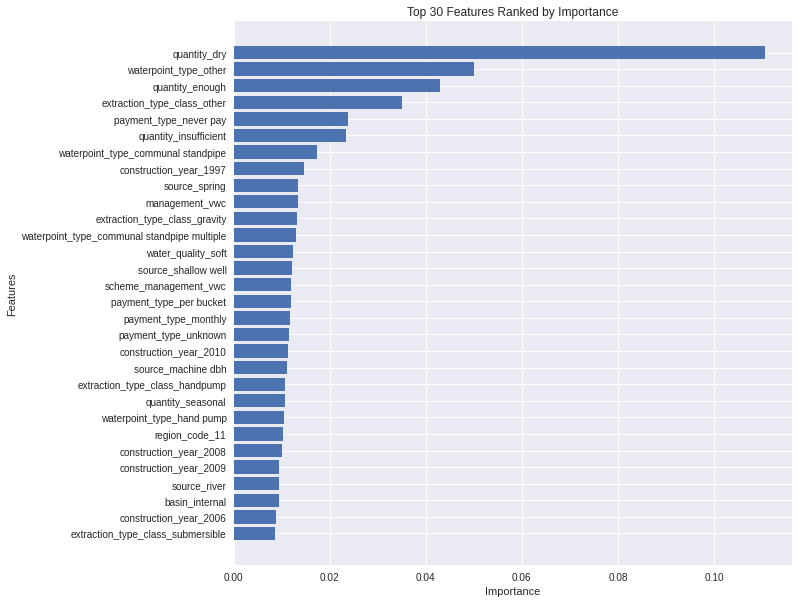

In [255]:
plot_feature_importance(base_rf_clf, ohe, X, num_features=30)


In [271]:
# Try tuning with GridSearchCV
 tuned_rf_clf = RandomForestClassifier(verbose=2)

 forest_param_grid = {"n_estimators" : [10, 50, 100],
                 'criterion' : ['gini', 'entropy'],
                 'max_depth' : [4, 6, 10],
                'min_samples_split' : [5, 10],
                'min_samples_leaf' : [3, 6]
                 }

 gs_forest = GridSearchCV(estimator=tuned_rf_clf, param_grid=forest_param_grid, 
                          scoring='accuracy', cv=3, 
                          verbose=2, n_jobs=-1)
 tuned_rf_clf.fit(X_train_encoded, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building

RandomForestClassifier(verbose=2)

In [272]:
print_accuracy(tuned_rf_clf, X_train_encoded, y_train, X_test_encoded, y_test, cm=True)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
Test accuracy: 78.5 %
Train accuracy: 86.4 %
[[5548  140  585]
 [ 419  214  129]
 [1103   97 3278]]
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished


#### GradientBoostingClassifer

In [257]:
# Baseline GradientBoostingClassifer
base_gbt_clf = GradientBoostingClassifier(max_depth=4, verbose=1, random_state=42)
base_gbt_clf.fit(X_train_encoded, y_train)


      Iter       Train Loss   Remaining Time 
         1           0.8440            2.53m
         2           0.8153            2.44m
         3           0.7922            2.39m
         4           0.7738            2.36m
         5           0.7586            2.32m
         6           0.7456            2.28m
         7           0.7347            2.25m
         8           0.7251            2.22m
         9           0.7165            2.20m
        10           0.7092            2.18m
        20           0.6644            1.96m
        30           0.6423            1.76m
        40           0.6283            1.56m
        50           0.6188            1.31m
        60           0.6103            1.06m
        70           0.6031           47.63s
        80           0.5976           31.68s
        90           0.5923           15.87s
       100           0.5869            0.00s


GradientBoostingClassifier(max_depth=4, random_state=42, verbose=1)

In [258]:
print_accuracy(base_gbt_clf, X_train_encoded, y_train, X_test_encoded, y_test, cm = True)

Test accuracy: 75.5 %
Train accuracy: 76.0 %
[[5871   29  373]
 [ 568   83  111]
 [1720   22 2736]]


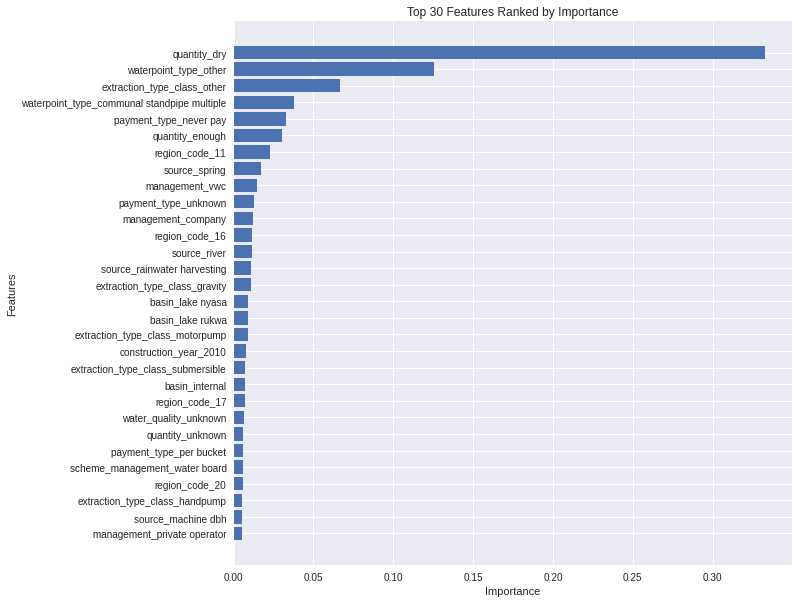

In [260]:
plot_feature_importance(base_gbt_clf, ohe, X, num_features=30)

### XG Boost Classifer


In [265]:
# XGBoost
base_xgbt_clf = XGBClassifier(verbosity=1)
base_xgbt_clf.fit(X_train_encoded, y_train)


XGBClassifier(objective='multi:softprob')

In [266]:
print_accuracy(base_xgbt_clf, X_train_encoded, y_train, X_test_encoded, y_test, cm=True)

Test accuracy: 73.7 %
Train accuracy: 73.7 %
[[5931   15  327]
 [ 609   57   96]
 [1968   18 2492]]


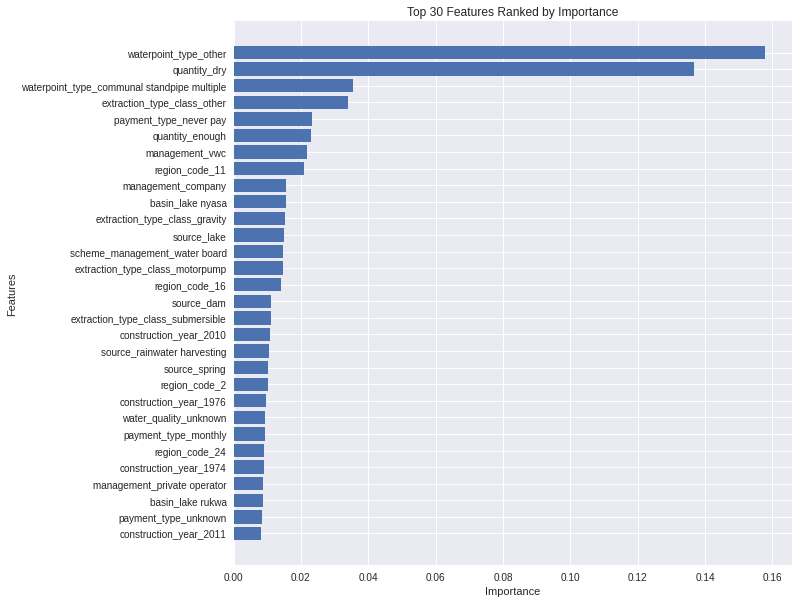

In [268]:
plot_feature_importance(base_xgbt_clf, ohe, X, num_features=30)

In [273]:

tuned_xgb_clf = XGBClassifier()

param_grid = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [6],
    'min_child_weight': [1, 2],
    'subsample': [0.5, 0.7],
    'n_estimators': [100],
}


gs_xgb = GridSearchCV(tuned_xgb_clf, param_grid, scoring='accuracy', cv=None, n_jobs=1, verbose=1)
gs_xgb.fit(X_train_encoded, y_train)


ValueError: DataFrame.dtypes for data must be int, float or bool.
                Did not expect the data types in fields basin, scheme_management, extraction_type_class, management, payment_type, water_quality, quantity, source, waterpoint_type

In [ ]:
print_accuracy(gs_xgb, X_train_encoded, y_train, X_test_encoded, y_test, cm=True)

In [ ]:
plot_feature_importance(gs_xgb, ohe, X, num_features=30)

In [ ]:
best_parameters = gs_xgb.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds = gs_xgb.predict(X_train)
test_preds = gs_xgb.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print('')
print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))

### Confusion Matrix goes here

In [29]:

# Alternative (AND NICER LOOKING) confusion matrix (may only work as coded for numeric targets...verify this)
##from sklearn.metrics import plot_confusion_matrix

#plot_confusion_matrix(classifier, X, y, values_format='.3g')
#plt.show()

# EXAMPLE
# AdaBoost model predictions
#adaboost_train_preds = adaboost_clf.predict(X_train)
#adaboost_test_preds = adaboost_clf.predict(X_test)

# GradientBoosting model predictions
#gbt_clf_train_preds = gbt_clf.predict(X_train)
#gbt_clf_test_preds = gbt_clf.predict(X_test)

'''
CLASSIFICATION REPORT EXAMPLE
adaboost_classification_report = classification_report(y_test, adaboost_test_preds)
print(adaboost_classification_report)
'''


### Consider showing most important features here

In [30]:
def plot_feature_importances(model):
    n_features = data_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), data_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

#plot_feature_importances(tree_clf)

#### Show the Accuracy and F1 Scores (if those are the metrics I decide to use)

In [ ]:
def display_acc_and_f1_score(true, preds, model_name):
    acc = accuracy_score(true, preds)
    f1 = f1_score(true, preds)
    print("Model: {}".format(model_name))
    print("Accuracy: {}".format(acc))
    print("F1-Score: {}".format(f1))

    '''
    Example here
    print("Training Metrics")
display_acc_and_f1_score(y_train, adaboost_train_preds, model_name='AdaBoost')
print("")
display_acc_and_f1_score(y_train, gbt_clf_train_preds, model_name='Gradient Boosted Trees')
print("")
print("Testing Metrics")
display_acc_and_f1_score(y_test, adaboost_test_preds, model_name='AdaBoost')
print("")
display_acc_and_f1_score(y_test, gbt_clf_test_preds, model_name='Gradient Boosted Trees')
'''

## Predict on Pump it Up Challenge Test/Validation dataset
The challenge submission process involved making predictions on their supplied Test/Validation dataset.  The challenge Training and Test/Validation dataset were already in an 80/20 split so I retrained my Classifier on the full Training dataset before making predictions.

To Do... 

In [ ]:


X_validate = pd.read_csv(
    '../data/testing_features.csv', 
    index_col='id'
)
y_validate = model.predict(
    X_validate
)
df_predictions = pd.DataFrame(
    y_validate, 
    index=X_validate.index, 
    columns=['status_group']
)
df_predictions.to_csv(
    '../predictions/final_model.csv'
)

## or


# predict with X_val_preprocessed
y_pred_val = best_model.predict(X_validate_encoded)

# reformat to submission format csv, maintain 'id' columns
df_y_pred_val = pd.DataFrame(y_pred_val, index=X_validate.index, columns=['status_group'])

# write out to file
##do this

#check format and prediction rate
display(df_y_pred_val.head())
df_y_pred_val['status_group'].value_counts(normalize=True)



